# Comparing various machine learning models for music genre classification

## Abstract
To tackle the problem of classifying the musical genre of songs based on "carefully chosen features", models such as XGBoost, random forest, support vector classifiers (SVC), k-nearest neighbour (KNN) classifiers, and deep neural networks were used. Data analysis showed high class imbalance in the dataset, and visualizations such as the correlation matrix of features, 3-dimensional PCA projection, and feature-class plots, show that many of the features are either non-informative or hardly separable between classes. Class imbalance wasn’t further dealt with, since the class imbalance is found in the final Kaggle validation data as well (and trying to fix this would give even worse results on the validation dataset). Class imbalance, combined with the low amount of labeled data points (about 4500), made it clear that this data will be difficult to fit. Feature scaling gave better results on most of the models. On the Kaggle dataset, almost all of the models yielded somewhat similar results (60%-67% accuracy). 



## 1. Introduction

### Background and motivation
Music genre classification is a compelling problem to solve with a machine, for music
database management, recommendation systems in music streaming services, smart playlist generation, and many other applications.

The task of finding a good algorithm to classify music genre is more difficult than it would appear at a first glance. It may not be that obvious, but the human perception of "natural" things, like images and sound, is non-trivial with an algorithm. The most popular approaches are with supervised machine learning, such as Bayesian methods [3], nearest neighbour methods [1, 3], decision trees [3],  Support Vector Machines [1, 3], and neural networks [1, 3], including recurrent neural networks [5] and convolutional neural networks (CNNs) [6].

There are many ways to represent music as data, such as Mel-frequency cepstral coefficients (MFCCs), spectral contrast and spectral roll-off [7]. Another common representation is the spectrogram of a signal. Spectrograms can even be considered as images and used to train CNNs [6].

### Problem statement
Since the “music genre classification” problem is presented here as labelling 10 classes from a dataset of just 4500 data points (not the raw acoustic signals), the approach here has been to try out a lot of simpler models with fewer numbers of parameters, the most complex being the 2- and 3-layer neural networks.

The more rigorous formulation of this problem goes as follows:
 - Given $X$, data matrix of 4363 data points and 264 features ($X\in\mathbb{R}^{4363,264}$) and labels $y\in\mathbb{R}^{4363}$ with each $y_i \in \{1, 2, ... , 10\} $
 - Each of the rows of the matrix $X$ represents a feature vector belonging to a particular song
 - Each of the numbers in $y_i$ represents one music genre
 
The task is to find an algorithm so that given a set of similar features $\hat{X}$ (disjoint from the training set), the algorithm will correctly predict which music genre that song belongs to.

These 264 features for the matrix $X$ belong to one of these 3 classes: Rhythm, Chroma and MFCC.

Data analysis showed that among the 4363 data points in $X$, the data is higly imbalanced (some classes have much higher number of data points than others). Moreso, the MFCC features seem to not have a large effect on the inference, since they are not very different among the classes. Visualization of the data values confirmed the need for scaling.

A larger emphasis has been placed on trying out a lot of models, especially models with in-built feature selection mechanisms, rather than focusing on manual feature engineering. The idea for this that since the public test dataset on Kaggle is imbalanced as well, with 51.0% labeled as pop rock, anything other than simply scaling the features did not yield better results, sometimes even giving worse results. Each model variant is evaluated "offline" on a held-out validation set split from 30% of $X$ as well as with cross-validation on all of $X$, and "online" Kaggle accuracies and log-losses. All of them have about the same performance, with XGBoost being the best.

## 2. Data analysis
The data represents songs which have had their audio information preprocessed into 264 features, so our data has high dimensionality. They have 10 possible classes, or music genres. The training set has 4363 songs, and the test set has 6544 songs.

The class distribution is **heavily imbalanced** towards "Pop Rock", which makes up 49.9% of the labels in the training set.

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
matplotlib.rcParams['figure.figsize'] = (14, 5)
matplotlib.rcParams['font.size'] = 12
from matplotlib import pyplot as plt

# Read data
train_data_df = pd.read_csv("data/train_data.csv", header=None)
test_data_df = pd.read_csv("data/test_data.csv", header=None)
all_data_df = train_data_df.append(test_data_df)
train_labels_df = pd.read_csv("data/train_labels.csv", header=None, 
                              names=['class'])

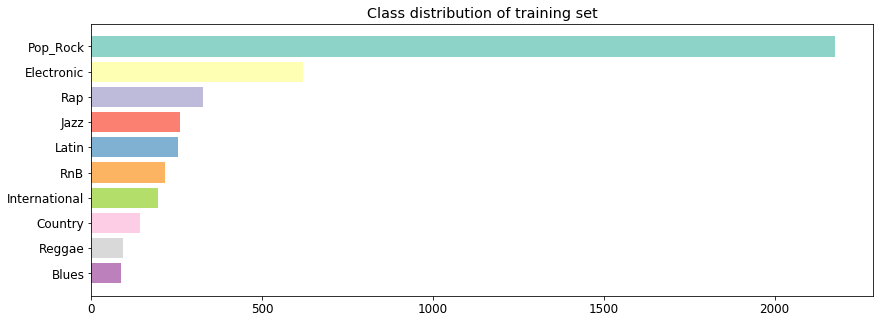

In [16]:
num_classes = 10
genres = ['Pop_Rock','Electronic','Rap','Jazz','Latin','RnB','International','Country','Reggae', 'Blues']
class_counts = train_labels_df['class'].value_counts()
cmap = plt.cm.get_cmap(plt.cm.Set3, 10)
colors = [cmap(i) for i in range(num_clbasses)]
plt.barh(range(num_classes)[::-1], class_counts, tick_label=genres,
         color=colors)
plt.title('Class distribution of training set')
plt.show()

## Sufficient statistics

Plotting some sufficient statistics (mean and standard deviation) of the features gives an idea of how informative each feature in each of the 3 given feature categories (rhythm, MFCC, and chroma patterns) would be.

On the first 24 features the **mean rhythm** clearly shows how "pop rock" has a much higher rhythm than any other labels. Some smaller differences can be observed on the rhythm's standard deviations as well. For example, "blues" has a lower trend on "varying rhythms" than the other genres.

MFCC features, in contrast with the rhythm features, look extremely plain. Among each class (each colour), for each one feature, all the data seems to be homogenous. Not much emphasis has been put on this (since the model will learn to ignore these non-informative features), but it clearly shows that there is a whole lot of data tuning that can be done to get better results, before even considering different models.

Lastly, the chroma values seem to be somewhere in between the other two categories. The classes aren't easily distinguishable, but some very complex patterns may nevertheless be drawn from these.

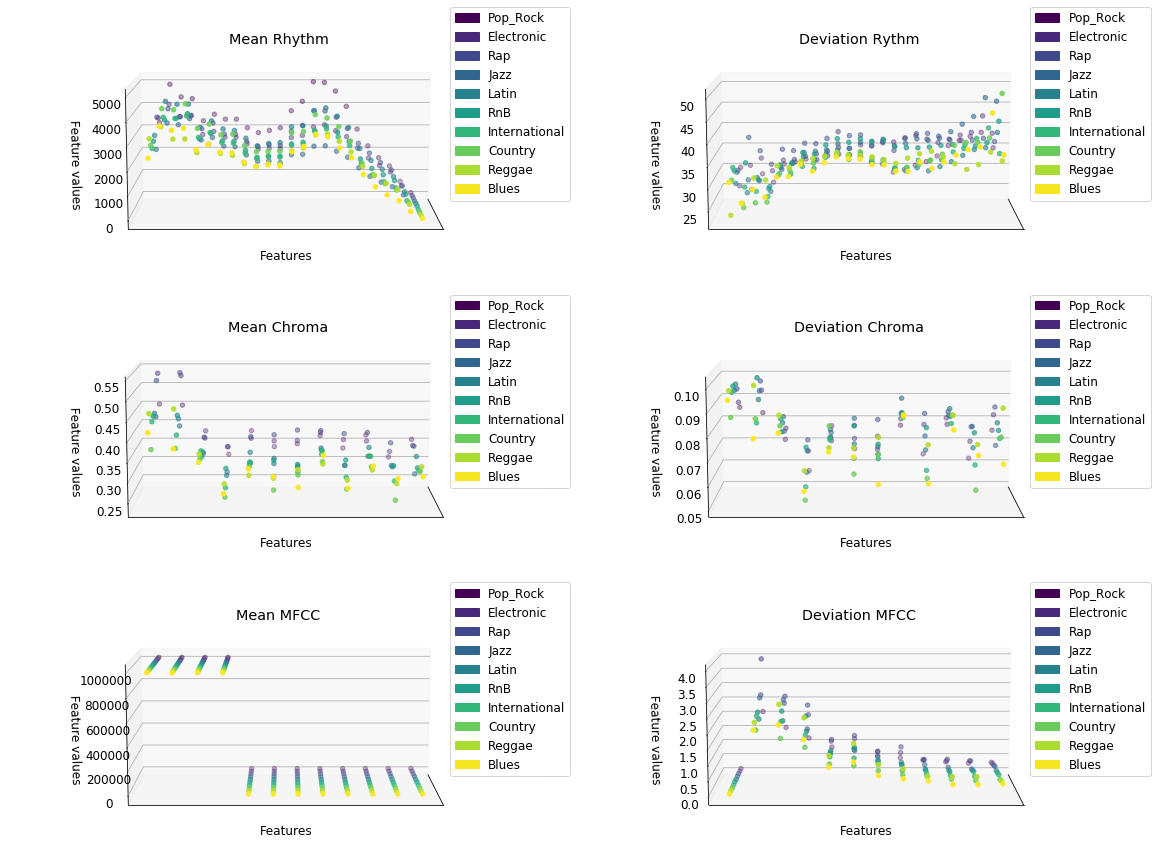

In [269]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

train_data = train_data_df.values
train_labels = train_labels_df.values
label_feature_means = []
for i in range(1,11):
    feature  = train_data[np.argwhere(train_labels == i)[:,0]]
    label_feature_means.append(np.mean(feature,axis=0))
label_feature_means = np.array(label_feature_means)
feature_indexes = np.array([[0,24],[48,72],[168,180],[180,192],[216,228],[228,240]])
graph_titles = ["Mean Rhythm","Deviation Rythm","Mean Chroma","Deviation Chroma","Mean MFCC","Deviation MFCC"]
plot_indexes = np.array([[0,3],[3,6],[0,3],[3,6],[0,3],[3,6]])
fig_size = plt.rcParams["figure.figsize"]
cmap = plt.cm.get_cmap(plt.cm.viridis, 10)
patches = []
for i in range(10):
    patches.append(mpatches.Patch(color=cmap(28*i),label=genres[i]))
fig_size[0] = 20
fig_size[1] = 15
gs = gridspec.GridSpec(3, 6)
gs.update(wspace=0.3)
fig = plt.figure()
for i in range(6):
    x = np.arange(0,10,1)
    y = np.arange(0,feature_indexes[i,1]-feature_indexes[i,0],1)
    c = np.array([np.repeat(i,len(y)) for i in x]).T
        
    ax=plt.subplot(gs[int(i/2),plot_indexes[i,0]:plot_indexes[i,1]],projection='3d')
    ax.set_title(graph_titles[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.view_init(elev=10,azim=0)
    xx, yy = np.meshgrid(x,y)
    ax.legend(handles=patches, loc=1, borderaxespad=-2)
    ax.set_ylabel("Features",labelpad=10)
    ax.set_zlabel("Feature values",labelpad=10)
    if i == 1:
        variance = label_feature_means[:,feature_indexes[i,0]:feature_indexes[i,1]]
        deviation = np.sqrt(variance)
        ax.scatter(xx,yy,deviation.T,c=c.flatten())
    else:
        ax.scatter(xx,yy,label_feature_means[:,feature_indexes[i,0]:feature_indexes[i,1]].T,c=c.flatten())
plt.show()



In [258]:
descriptive_stats = all_data_df.describe()

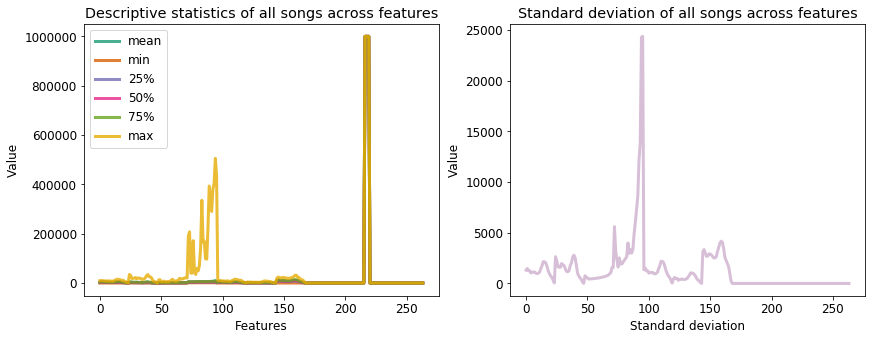

In [12]:
tab10_cmap = plt.cm.get_cmap(plt.cm.Dark2, 10)
value_stats = ['mean', 'min', '25%', '50%', '75%', 'max']
plt.subplot(1, 2, 1)
for i, stat in enumerate(value_stats):
    plt.plot(descriptive_stats.loc[stat], label=stat, lw=3, alpha=0.8, color=tab10_cmap(i))
plt.ylabel("Value")
plt.xlabel("Features")
plt.legend()
plt.title("Descriptive statistics of all songs across features")

plt.subplot(1, 2, 2)
plt.plot(descriptive_stats.loc['std'], label=stat, lw=3, color='thistle')
plt.ylabel("Value")
plt.xlabel("Standard deviation")
plt.title("Standard deviation of all songs across features")

plt.show()

**Features 216-219** have huge mean, min, max, and quartiles of exactly 1,000,000 for both train and test sets: this is because these features are uniformly 1,000,000 for all songs, meaning that they are **completely uninformative features** and should be ignored by the training algorithm.

In [46]:
all_data_df.iloc[:, 216:220].T

,0,1,2,3,4,5,6,7,8,9,...,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543
216,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
217,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
218,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0
219,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,...,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0,1000000.0


Features 72-95, especially 72 and 88-95, also have very high max values compared to the 75th percentiles, which implies that **they have statistical outliers**. This is supported by the **unusually high variance** of features 72 and 88-95. These outliers will then impede dimensionality reduction via PCA, because the high variances will mislead PCA into heavily using these features in the primary component (see PCA section).

## Correlation matrix
The Pearson product-moment correlation coefficients of **all** the features in the training set is visualized in the matrix below. Red indicates a positive correlation and blue a negative correlation, while lighter shades mean the features are not correlated.

We can see that there some features are uncorrelated with all other features. For example, all 7 statistical descriptors of one of the 24 rhythm patterns is represented as the 7 thin horizontal and vertical white lines at the top of the triangle, and the completely uninformative features 216-219 in the MFCC features are seen as thicker white bands.

If two features are highly correlated, we can consider eliminating one of them as they might be redundant.

Highly correlated features can also be problematic for some algorithms, e.g. naive Bayes classifiers, which assume the features are independent given the class. 

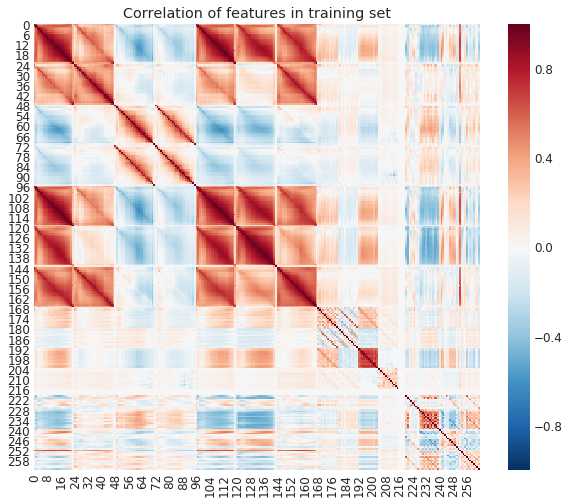

In [270]:
np.seterr(divide='ignore', invalid='ignore')
corr = np.corrcoef(train_data_df.T)
corr = np.nan_to_num(corr)  # Convert NaN's to zero
mask = np.zeros_like(corr)  # Mask out the upper triangle
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu_r", 
                square=True, cbar_kws={"shrink": .82})
plt.title("Correlation of features in training set")
plt.show()

## Value distributions of features

From a visualization of the distributions of features, we can easily spot that some of the features are uniformly 1,000,000 (the blue horizontal line).

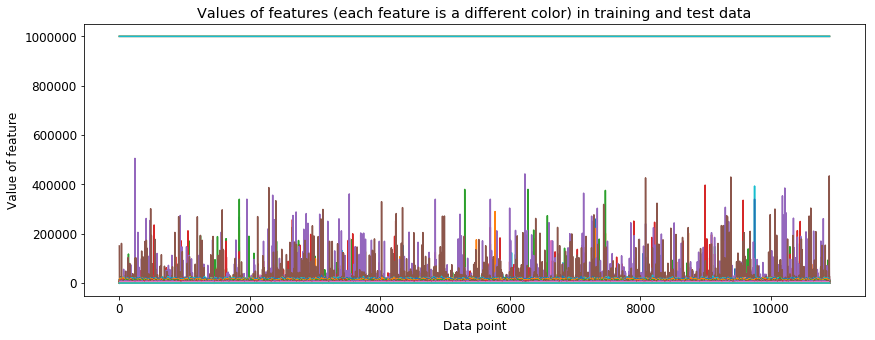

In [108]:
num_train_data, num_features = train_data_df.shape
indices = list(range(num_features))
for i in indices:
    plt.plot(all_data_df[i].values)
plt.xlabel("Data point")
plt.ylabel("Value of feature")
plt.title("Values of features (each feature is a different color) in training and test data")
plt.show()

After removing the useless features, the plot improves. However, there are still visibly huge differences in the ranges of different features. For some machine learning algorithms, this is undesirable (see Discussion).

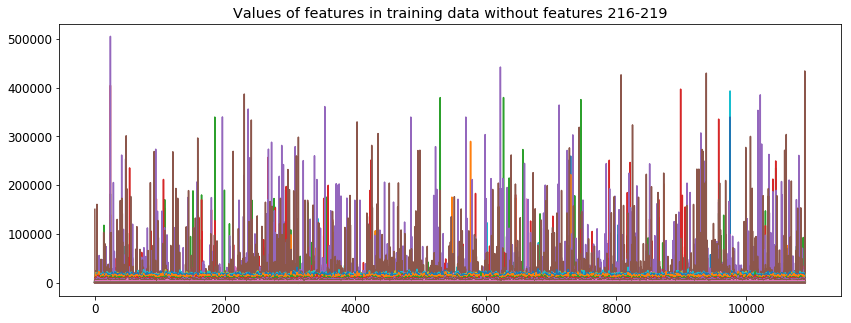

In [69]:
# Remove features 216-219 which have huge values
del indices[216:220]

for i in indices:
    plt.plot(all_data_df[i].values)
plt.title("Values of features in training data without features 216-219")
plt.show()

For each feature $x_i$ in each row of the input data, we rescale it such that its value is now between 0 and 1.
$$\dfrac{x_i – min(x)}{max(x) – min(x)}$$

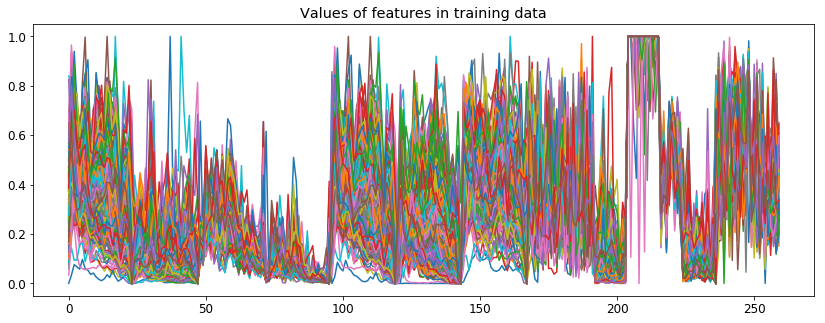

In [94]:
from sklearn import preprocessing
# Scale
min_max_scaler = preprocessing.MinMaxScaler()
scaled_data = min_max_scaler.fit_transform(train_data_df)
del indices[216:220]
for i in indices:
    plt.plot(scaled_data[i])
plt.title("Values of features in training data")
plt.show()

Before scaling the features, the 3-D PCA projection is tightly clustered in the latent space.

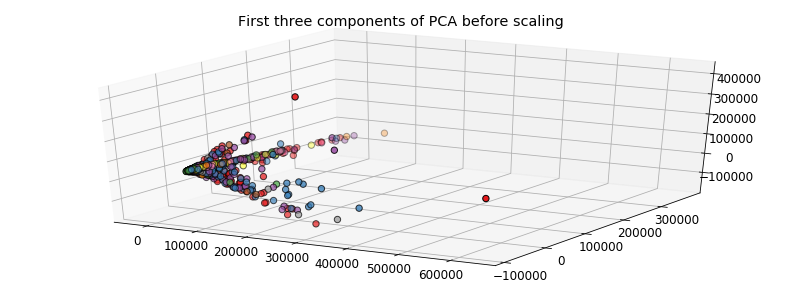

In [105]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(train_data_df)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA before scaling")

plt.show()

In [60]:
train_data_df = train_data_df.drop([216, 217, 218, 219], axis=1)
test_data_df = test_data_df.drop([216, 217, 218, 219], axis=1)

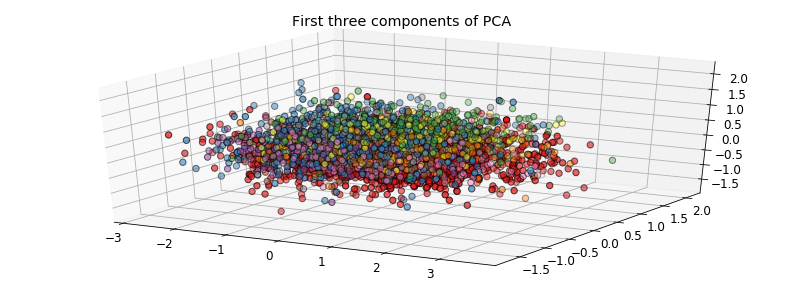

In [92]:
scaled_data = min_max_scaler.fit_transform(train_data_df)

pca = PCA(n_components=3)
PCA3_data = pca.fit_transform(scaled_data)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(PCA3_data[:, 0], PCA3_data[:, 1], PCA3_data[:, 2], c=train_labels_df['class'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three components of PCA")

plt.show()

After min-max scaling the training data, the PCA visualization is much more distributed across the latent space, with relatively clearer regions for different classes.

# Methods and experiments

## Preprocessing
We use `MinMaxScaler` to scale all features, as mentioned in the previous section. A 70-30 split on the labeled training dataset is done in the beginning, and all the algorithms below are initially trained with the 70% training set and scored on both the training set and the 30% validation set. After tuning the hyperparameters with the validation set (test set), the final models are then

## 1. Neural network
Trained 2 and 3 layer networks, fully connected, with sigmoid activation. The networks combined hyperparameters, 5 for dropout and 5 for the learning rate, resulting in 25 models for the 2 and 3 layer respectively. 

### Model parameters (matrices for each layer)

- 2 layer model:
    - First layer: $264 \times 264$
    - Second layer: $264 \times 10$
- 3 layer model:
    - First layer: $264 \times 528$
    - Second layer: $528 \times 264$
    - Thrird layer: $264 \times 10$

## 2. XGBoost

### How it works
Gradient Tree Boosting is a generalization of boosting to arbitrary differentiable loss functions. Accurate and effective.

XGBoost is a gradient boosting algorithm that accumulates weak learners and creates an ensemble. It is a popular library because it is has clever penalisation of Trees, A Proportional shrinking of leaf nodes Newton Boosting Extra Randomisation Parameter to reduce correlation between the trees

The advantages of GBRT are:

- Natural handling of data of mixed type (= heterogeneous features)
- Predictive power
- Robustness to outliers in output space (via robust loss functions)

The disadvantages of GBRT are:

- Scalability, due to the sequential nature of boosting it can hardly be parallelized.
### Motivation
Good performance in data science competitions.
### Experiments
We train 200 weak learners with early stopping.
Train with early stopping if there is no improvement in the logarithmic loss

## 3. SVC
a linear SVM creates a hyperplane that uses support vectors to maximise the distance between the two classes.. for multiclass setting, we train 10 one-vs-rest classifiers. However, one minor implementation detail is that we used sklearn's `LinearSVC` implementation which regularizes the bias, unlike a conventional SVC.

`LinearSVC` implements “one-vs-the-rest” multi-class strategy, thus training 10 models--. If there are only two classes, only one model is trained:

To transform the decision function outputs into a probability vector, we Platt’s sigmoid model [8], and then compute the validation log-loss based on that.


## Voting Ensemble
We take the algorithms that are already conveniently inherits from Sklearn's BaseEstimator, and use them for various ensembling techniques

VotingClassifier, BaggingClassifier, AdaboostClassifier.


‘soft’ voting predicts the class label based on the argmax of the sums of the predicted probabilities.
Sequence of weights (float or int) to weight the class probabilities before averaging (soft voting). 


##  Evaluation

### Validation performance metrics
We **split the labeled training dataset into 30% validation set and keep the remaining 70% for training**. Then we use the validation logloss and accuracy as an "offline" proxy for its "online" performance on unseen data, i.e. on the private Kaggle test sets.

This is useful for determining early stopping (stopping training at the point where the model is not improving anymore on the test set and only overfits on the training set). E.g. for the best performing neural networks below, there is a clear point after which the test set accuracy is constant while the train set accuracy continues to climb, indicating overfitting.

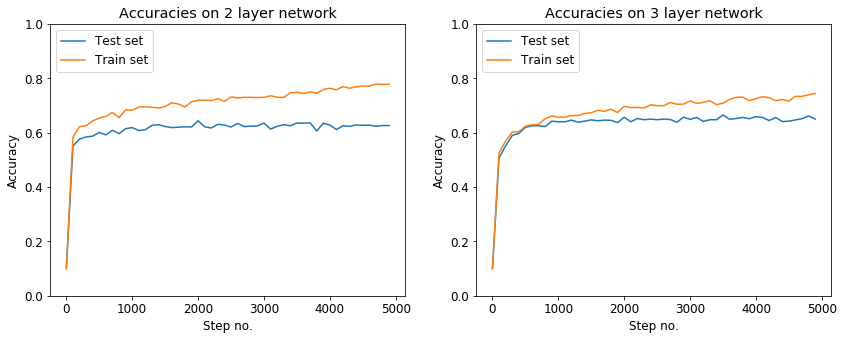

In [231]:
indexes = np.linspace(0,49,50)*100
hmaps.test_accuracy_2L.shape
hmaps.train_accuracy_2L.shape
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(indexes,hmaps.test_accuracy_2L,label="Test set")
plt.plot(indexes,hmaps.train_accuracy_2L,label="Train set")
plt.legend(loc="upper left")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Step no.")
plt.title("Accuracies on 2 layer network")
plt.subplot(1, 2, 2)
hmaps.test_accuracy_2L.shape
hmaps.train_accuracy_2L.shape
plt.plot(indexes,hmaps.test_accuracy_3L,label="Test set")
plt.plot(indexes,hmaps.train_accuracy_3L,label="Train set")
plt.legend(loc="upper left")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("Step no.")
plt.title("Accuracies on 3 layer network")
plt.show()



However, estimating the model's performance with a held-out validation set has a high variance due to differences in the training and validation sets.

### Cross-validation for performance metrics
For the algorithms that are faster to train, we also use a *better (lower variance) but more computationally expensive* benchmark: **stratified k-fold cross validation**. We split the training set into $k$ folds, where the algorithm is run $k$ times on $k-1$ folds and tested on the held-back fold; each fold of the dataset is held back once. We use $k=3$, similar to how we did a 30-70 split when computing the traditional validation metrics.

Since our data has a class imbalance, we use **stratified folds** which enforce the same distribution of classes in each fold as in the whole training dataset.

This metric had a better correlation with the Kaggle performance. There were several cases where, the validation accuracy and log-loss looked promisingly good but the cross-validated scores were more realistic and indicative of its online performance. The inverse is also possible. For example, the ensemble of XGBoost and RandomForest performed well on Kaggle (0.65359) and also had high cross-validation scores (0.62737), but the performance metrics on the validation set were low: an accuracy of 0.51948.

![ensemble-xgb-rf cm](img/cm_ensemble_rf_xgb.png)

On Kaggle, a naive submission that classifies everything as "pop rock" gives an accuracy of 0.50993.

### Confusion matrix
The confusion matrices for the chosen models on the offline test dataset. As expected, the first label (first class) is the predominant class chosen by the model when it predicts wrong (since the model is trained on a highly imbalanced dataset, with a lot of class 1 rows).


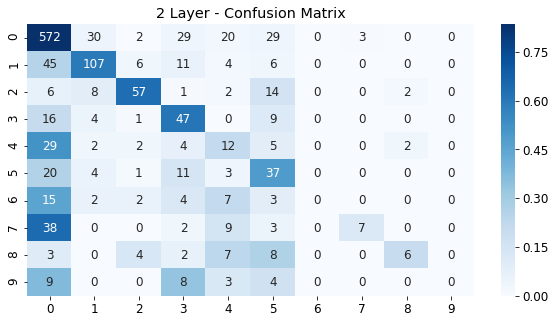

In [246]:
hmaps.conf_matrix()
def get_proportions(confusion_values):
    props = []
    for i in range(10):
        props.append(confusion_values[i,:]/np.sum(confusion_values[i,:]))
    return props
proportions_2L = get_proportions(hmaps.conf_matrix_2L)
plt.figure(figsize=(10,5))
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("2 Layer - Confusion Matrix")
sns.heatmap(proportions_2L,cmap="Blues",annot=hmaps.conf_matrix_2L, fmt=".0f")
plt.show()


### AUC ROC
This is a proxy for how good the confusion matrix looks.
Either a `weighted` or `macro` averaging of the Area Under the Received Operating Characteristic Curve (ROC AUC) scores for each class on the validation set. Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. `weighted` Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).

The `weighted` averaging of AUC scores will weight each class proportionately to the original class imbalance.

If we want to see how it would perform if all clases were uniform, we can look at the `macro` averaging which gives all classes the same weight.

## Tuning hyperparameters
### Neural network
Heatmaps were ploted for the maximum accuracy of each of the models and for each, a matrix of the training steps at which the maximum accuracy was found (used to find at which step each of the model starts to overfit).

Each of the two models (2-layer and 3-layer) were trained on every combination of the following hyperparameters:
- Dropout: [0.3, 0.2, 0.15, 0.1, 0.05]
- Learning rate: [0.001, 0.003, 0.005, 0.01, 0.03]

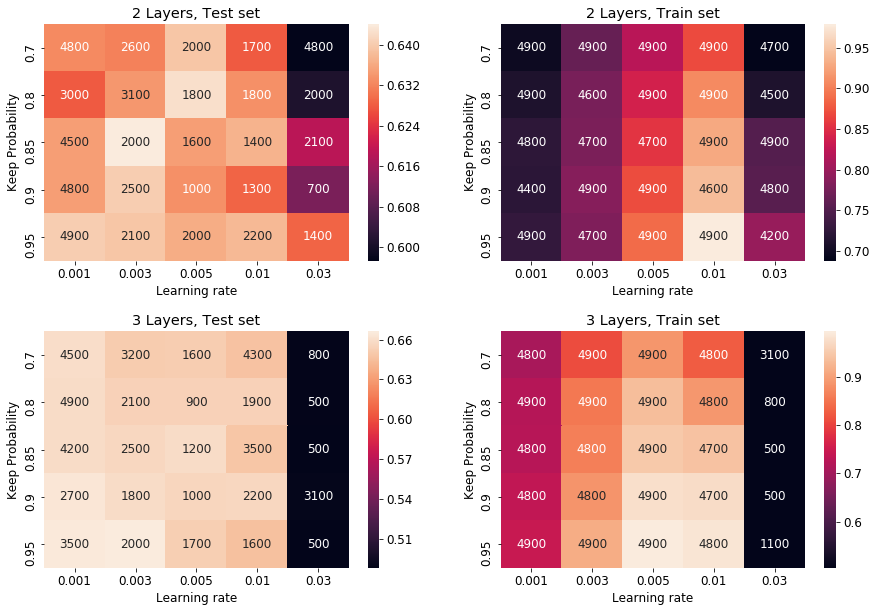

In [227]:
import analysis
hmaps = analysis.NN_heatmaps()
hmaps.hmaps()
hmaps.convert_numpy()
hmaps.accuracy_results()
learning_rate_ = [0.001, 0.003, 0.005, 0.01, 0.03]
keep_prob_ = [0.7, 0.8, 0.85, 0.9, 0.95]

matplotlib.rcParams['figure.figsize'] = (15, 10)
plt.subplot(2, 2, 1)
steps_2_test = hmaps.heat_map_2_test_steps[:5,:]
sns.heatmap(hmaps.heat_map_2_test[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
           annot=steps_2_test, fmt="d")
plt.title("2 Layers, Test set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 2)

sns.heatmap(hmaps.heat_map_2_train[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
           annot=hmaps.heat_map_2_train_steps[:5,:], fmt="d")
plt.title("2 Layers, Train set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 3)

sns.heatmap(hmaps.heat_map_3_test[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
            annot=hmaps.heat_map_3_test_steps[:5,:], fmt="d")
plt.title("3 Layers, Test set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.subplot(2, 2, 4)

sns.heatmap(hmaps.heat_map_3_train[:5,:],xticklabels=learning_rate_,yticklabels=keep_prob_,
            annot=hmaps.heat_map_3_train_steps[:5,:], fmt="d")
plt.title("3 Layers, Train set")
plt.xlabel("Learning rate")
plt.ylabel("Keep Probability")
plt.show()
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

The colors represent the accuracy, and the printed numbers represent the step at which the accuracy was maximum.

### Chosen models
For each type (2-layer or 3-layer), the model with the highest test accuracy was chosen:
- 2 layer: keep_probability=0.85 (equivalent to dropout 0.15) and learning_rate= 0.003, trained for 2000 steps
- 3 layer: keep_probability=0.95 (equivalent to dropout 0.05) and learning_rate= 0.001, trained for 3500 steps

## Linear SVC
As LinearSVC is a fast algorithm, we also did a parameter grid search on the regularization function (l1 or l2 loss) and the value of the penalty parameter C.

![search](img/gridsearch_LinearSVC.png)



In [100]:
from tensorflow.contrib.losses import tf_log_loss
from sklearn.metrics import accuracy_score, log_loss

eval_predicted_proba = model.predict_proba(eval_data)
onehot = to_categorical(eval_labels).astype(int) # Splits into classes from 0-10 (11 classes)
eval_onehot = onehot[:, 1:]  # Trim unnecessary first column (class "0")

log_loss(eval_onehot, eval_predicted_proba)
accuracy_score(eval_)

# Results

## Experimental outcomes

The "offline" log-loss and accuracy are computed with stratified K-fold cross-validation on the faster algorithms, and computed directly on the validation set for the neural networks. Only the models with the best "offline" performances are chosen to be scored "online" on Kaggle.

For `final` models, there is no splitting between validation and test sets and they are trained with 100% of the training data. Since we compute AUC on the validation set, the AUC score cannot be computed on the `final` models.

| Model                         | Log-loss [s.d.]    | Accuracy [s.d.]    | AUC (weighted/macro) | Kaggle (L-L) | Kaggle (Acc.) |
|-------------------------------|--------------------|--------------------|----------------------|--------------|---------------|
| XGBoost                       | 1.10483 [0.031224] | 0.64055 [0.01678]  | 0.87161/0.86431      |      0.17474 |       0.64798 |
| XGBoost (S)                   | 1.11093 [0.034256] | 0.63661 [0.017100] | 0.87104/0.86205      |              |               |
| XGBoost (S, D)                | 1.12689 [0.02131]  | 0.63196 [0.00806]  | 0.87152/0.86687      |              |               |
| random forest                 | 1.26570 [0.00887]  | 0.58742 [0.00146]  | 0.85220/0.84101     |              |               |
| random forest (S)             | 1.25397 [0.01027]  | 0.60622 [0.00972]  | 0.99831 /0.99956     |      0.19964 |       0.60163 |
| random forest (S, D)          | 1.25178 [0.02163]  | 0.59497 [0.00607]  | 0.85150/0.84345      |              |               |
| random forest (balanced)      | 1.36745 [0.02399]  | 0.59300 [0.00134]  | 0.84223/0.82973      |              |               |
| linearSVC                     | 1.21057 [0.63713]  | 0.59366 [0.00369]  | 0.84733/0.82310      |              |               |
| linearSVC (S)                 | 1.13869 [0.01445]  | 0.64013 [0.00716]  | 0.86487/0.85752      |      0.19221 |       0.61487 |
| linearSVC (S, D)              | 1.13972 [0.01345]  | 0.63817 [0.00583]  | 0.86474/0.85722      |              |               |
| **final** XGBoost             | 1.09515 [0.00780]  | 0.65460 [0.00425]  | -                    |      0.17077 |       0.66225 |
| **final** random forest (S)   | 1.35585 [0.02808]  | 0.60577 [0.00487]  | -                    |            0.21831 |             0.57208 |
| **final** linearSVC (S)       | 1.16738 [0.01001]  | 0.64130 [0.00309]  | -                    |            0.22089 |             0.52419 |
| **final** 2-layer neural network    | 0.23542 \* \*\*         | 0.64400 **         | -                    |      0.23639 |       0.62913 |
| **final** 3-layer neural network    | 0.24244 \* \*\*         | 0.66539 **         | -                    |       0.2499 |       0.59093 |
|-------------------------------|--------------------|--------------------|----------------------|--------------|---------------|
| ensemble (XGB, RF)            | 1.14183 [0.01128]  | 0.62737 [0.00150]  | 0.65397/0.62538      |      0.17287 |       0.65359 |
| ensemble (unfitted XGB, RF)   | 1.16674 [0.00728]  | 0.63523 [0.00491]  | 0.87064/0.86256      |              |               |
| **final** ensemble (XGB, RF)  | 1.14325 [0.00340]  | 0.65482 [0.00234]  | -                   |     0.17773 | 0.65664  |
| ensemble (XGB, RF, SVC)       | 1.14984 [0.00764]  | 0.62344 [0.00535]  | 0.87358/0.86394      |              |               |
| **final** ensemble (XGB, RF, SVC) | 1.13104 [0.00655]  | 0.65505 [0.00686]  | -                    |      0.17544 |       0.66123 |

\* computed with `tf.losses.log_loss` (instead of `sklearn.metrics.log_loss`)

\** scored on held-out validation set



# Discussion

## Pitfalls of evaluation metrics
### Accuracy
Accuracy can be highly misleading on an imbalanced dataset. If the majority class is large, simply guessing the majority class yields a highly accurate classifier.

### Log-loss
While accuracy only cares about the class with the highest probability, log-loss penalizes predictions differently according to its confidence levels. A misprediction with a high confidence will be penalized much more than a misprediction with a lower confidence. Therefore, log-loss is a more informative indicator of a classifier's performance, as well as a better objective function for optimizing an algorithm.

However, if we care about predicting some classes accurately more than other classes, then log-loss is not a good metric as log-loss treats them equally. In this case, other metrics would be precision-recall, ROC-AUC, F-scores, and confusion matrices.

## Evaluation of results
The 2 layer network had a higher accuracy than the 3 layer network. A simple explanation for this would be that deep learning networks work extremly well when it comes to very large amounts of data, but are prone to overfitting when the dataset is small, so the simpler model (2 layer one) was able to generalize a bit better, even though the top accuracies for the "offline" case belong to the 3 layer model.

XGBoost yields the best performance, which is unsurprising given its success in many data science competitions. This ______________

The results obtained here cannot be directly compared to that of other approaches in this specific task, since the datasets are different.


## Impact of feature engineering
Scaling and dropping features does not improve XGBoost performance and even degrades it very slightly; this is likely because the algorithm has automatic feature selection; it learns to ignore outliers and uninformative features. 

Dropping the uninformative features (216-219) did not have an impact on any of the classifiers. As we can see from the feature importance graphs, all 3 algorithms successfully ignored the uninformative features perfectly.

However, scaling does slightly improve the performance of the random forest, although random forest is overall worse than XGBoost. Giving each class weights inversely proportional to class frequencies in the input data did not improve the performance metrics or the AUC score either.

Scaling also improves linearSVC by around 4.5% in accuracy and 0.0726 in log-loss. It is important to scale the input features before training a support vector machine, because SVM's will prioritize features of higher order of magnitude over lower magnitude features.

## Balancing the classes
Having a balanced random forest classifier degrades the log-loss slightly (0.01) as well as accuracy (1%). Using a balanced SVC degrades it far more with accuracy drops of around 10%, as SVC will prioritize values of higher magnitude.

## Suggestions for future research/improvement.

### Ensemble methods
Adding more such as a neural network
Other than voting classifier, there are other ensemble methods that can be explored as well.

### Further hyperparameter tuning
While the hyperparameters for SVC and neural networks were tuned with grid search, XGBoost and random forest classifiers were not. Further finetuning will very likely improve results[9].

### Hyperparameter tuning methods
Many better methods for tuning model hyperparameters exist. The naive way used here is exhaustive grid search, but alternatives include randomized grid search, Bayesian optimization[10], evolutionary algorithms [11], and more [12, 13].


# References
[1] Haggblade, M., Hong, Y., & Kao, K. (2011). Music Genre Classification.

[2] Goulart, A., Guido, R., Maciel, C.: Exploring different approaches for music genre classification. Egypt. Inf. J. 13(2), 59–63 (2012)

[3]  Carlos Nascimento Silla Jr., Alessandro L. Koerich, Celso A. A. Kaestner: A Machine
Learning Approach to Automatic Music Genre Classification. J. Braz. Comp. Soc.
14(3): 7-18 (2008).

[4] Gunn, Steve R. "Support vector machines for classification and regression." ISIS
technical report 14.1 (1998): 5-16.

[5]  J. Irvin, E. Chartock, N. Hollander, “Recurrent Neural Network with Attention for
Genre Classification”, 2016

[6] Lonce Wyse. 2017. Audio spectrogram representations for processing with convolutional neural networks. arXiv preprint arXiv:1706.09559.

[7] George Tzanetakis and Perry Cook. 2002. Musical genre classification of audio signals. IEEE Transactions on speech and audio processing 10(5):293–302.


[8] Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods, J. Platt, (1999)

[9] Félix Revert. (2018). Fine-tuning XGBoost in Python like a boss. https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e

[10] https://github.com/hyperopt/hyperopt

[11] https://github.com/EpistasisLab/tpot

[12] https://github.com/reiinakano/xcessiv

[13] https://github.com/automl/auto-sklearn

# Appendix

## KNN